## Setup

In [1]:
import os.path as osp

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [5]:
# If on colab

from google.colab import drive

drive.mount("/content/drive")

BASE_DIR = "/content/drive/MyDrive/Network ML/Project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# If local
BASE_DIR = "/Users/giacomoorsi/DocsNotSynced/EPFL/Dataset/Twitter/"

## Graph

We work in this project with Twitter's retweet graph. The graph is directed and unweighted. The nodes are Twitter users and the edges are retweets, with an edge from user A to user B if A retweeted B.

In [6]:
G = nx.read_graphml(osp.join(BASE_DIR, "users_clean.graphml"))

In [7]:
# Print descriptive statistics such as number of nodes, edges, etc.
print(
    f"The graph contains {G.number_of_nodes()} nodes and {G.number_of_edges()} edges."
)

The graph contains 100386 nodes and 2286592 edges.


## Node attributes

In [8]:
df = pd.read_csv(osp.join(BASE_DIR, "users_neighborhood_anon.csv"), index_col=0)

In [9]:
# remove user_id from index and add it as a column
df.reset_index(inplace=True)

For a description of features see https://www.kaggle.com/datasets/manoelribeiro/hateful-users-on-twitter

We only keep the features that represent attributes from the Twitter profile and from the text of the tweets, i.e. we remove the features that can be computed from the graph. Specifically, we do not consired the features aggregated from neighbors, since we will use Graph Machine Learning methods that, hopefully, extract the same kind of information in better ways. We also do not consider the features that are computed from the graph structure, such as centrality measures, since we will extract them ourselves later.

In [10]:
columns = list(df.columns)

features = [
    "user_id",
    "hate",
    # "hate_neigh",
    # "normal_neigh",
    "statuses_count",
    "followers_count",
    "followees_count",
    "favorites_count",
    "listed_count",
    # "betweenness",
    # "eigenvector",
    # "in_degree",
    # "out_degree",
    "sentiment",
    "subjectivity",
    "number hashtags",
    # "hashtags",
    "tweet number",
    "retweet number",
    "quote number",
    "status length",
    "number urls",
    "baddies",
    "mentions",
    # "is_50",
    # "is_63",
    # "is_50_2",
    # "is_63_2",
    "time_diff",
    "time_diff_median",
    "created_at",
]

features += list(
    filter(lambda x: x.endswith("_empath") and not x.startswith("c_"), columns)
)
features += list(
    filter(lambda x: x.endswith("_glove") and not x.startswith("c_"), columns)
)

In [11]:
df

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,c_feminine_empath,c_medieval_empath,c_journalism_empath,c_farming_empath,c_plant_empath,c_shopping_empath,c_ship_empath,c_religion_empath,c_tourism_empath,c_power_empath
0,0,normal,True,True,101767,3504,3673,81635,53,100467.895084,...,0.001380,0.003288,0.000255,0.002189,0.000593,0.003689,0.003559,0.001634,0.002662,0.007487
1,1,other,False,False,2352,19609,309,61,197,0.000000,...,0.000802,0.004465,0.000444,0.001632,0.001298,0.002183,0.008969,0.004975,0.000647,0.003419
2,2,other,False,False,1044,2371,2246,561,16,4897.117853,...,0.000985,0.005284,0.000554,0.001084,0.001359,0.002041,0.016846,0.004881,0.001214,0.003347
3,3,other,False,False,167172,3004,298,3242,53,9.864754,...,0.001391,0.002061,0.001116,0.001282,0.000000,0.001951,0.015423,0.000446,0.000446,0.005241
4,4,other,False,False,1998,17643,19355,485,239,0.000000,...,0.000633,0.035382,0.000317,0.000475,0.000475,0.002431,0.007656,0.033273,0.072792,0.003698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100381,100381,other,False,False,6425,70081,551,1770,223,91339.873881,...,0.000306,0.005301,0.000867,0.001511,0.000867,0.002858,0.011876,0.003625,0.001255,0.005197
100382,100382,other,False,True,16928,62727,463,52132,100,68208.504656,...,0.000387,0.003703,0.000586,0.002220,0.000872,0.005985,0.007646,0.002230,0.002274,0.009827
100383,100383,other,False,False,1118,12885,29,0,598,80904.560366,...,0.000229,0.003623,0.000946,0.002061,0.001571,0.002724,0.019474,0.003187,0.001069,0.005130
100384,100384,other,False,False,3359,517,137,595,17,37072.184175,...,0.001800,0.002066,0.000414,0.001858,0.000242,0.003691,0.005644,0.000885,0.001152,0.005624


In [12]:
df = df[features]
df

,user_id,hate,statuses_count,followers_count,followees_count,favorites_count,listed_count,sentiment,subjectivity,number hashtags,...,290_glove,291_glove,292_glove,293_glove,294_glove,295_glove,296_glove,297_glove,298_glove,299_glove
0,0,normal,101767,3504,3673,81635,53,0.035132,0.431656,16.0,...,-0.162803,0.022277,-0.061740,-0.108736,0.095297,0.014048,-0.079171,-0.064034,0.039573,0.121562
1,1,other,2352,19609,309,61,197,0.088142,0.418649,40.0,...,-0.220041,0.061212,0.045925,-0.090857,0.033579,-0.038353,-0.068932,-0.076778,0.016700,0.081580
2,2,other,1044,2371,2246,561,16,0.117861,0.455828,328.0,...,-0.071102,0.044288,0.044124,-0.058129,-0.026722,-0.034385,-0.015848,-0.033579,-0.015725,0.110611
3,3,other,167172,3004,298,3242,53,0.261688,0.558544,127.0,...,-0.085447,0.039014,0.014094,-0.090334,0.155788,-0.006964,-0.071013,-0.043521,0.023655,0.126403
4,4,other,1998,17643,19355,485,239,0.121533,0.435334,1710.0,...,-0.162940,0.112401,-0.109144,-0.143494,-0.015770,0.184437,0.015669,0.074143,-0.107558,-0.102976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100381,100381,other,6425,70081,551,1770,223,0.174331,0.511019,241.0,...,-0.101585,0.056177,-0.011879,-0.079700,0.057477,-0.037915,-0.044164,-0.029799,-0.056733,0.108609
100382,100382,other,16928,62727,463,52132,100,0.227946,0.571372,69.0,...,-0.048893,-0.034731,-0.102936,-0.107279,0.135280,-0.022714,-0.062393,-0.037941,-0.016274,0.070525
100383,100383,other,1118,12885,29,0,598,0.182165,0.446904,143.0,...,-0.139124,0.025163,0.048279,-0.062656,0.027198,-0.054500,-0.013992,-0.046172,-0.037651,0.112789
100384,100384,other,3359,517,137,595,17,0.116135,0.541092,97.0,...,-0.140663,0.020672,-0.031872,-0.104729,0.103883,-0.035841,-0.071515,-0.048701,0.055673,0.084698


# 1. Preliminary exploration
In this section, we carry out some exploratory analysis of the dataset. 
We will have a look at: 
1. The degree distribution of the graph
2. Connectivity of the graph
3. The distribution of the features
4. The correlation between features and labels

### 1.1 Degree distribution

In [13]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

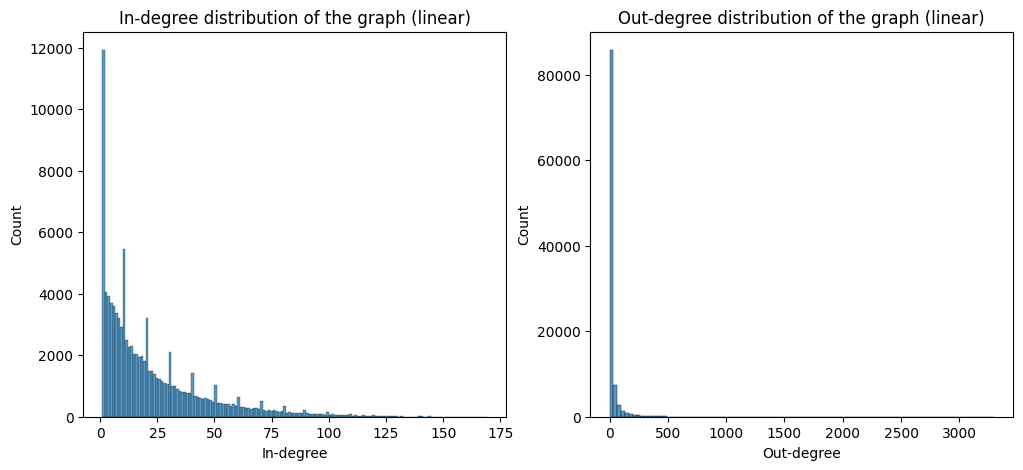

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(in_degrees, ax=ax[0])
sns.histplot(out_degrees, bins=100, ax=ax[1])
ax[0].set_xlabel("In-degree")
ax[1].set_xlabel("Out-degree")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
ax[0].set_title("In-degree distribution of the graph (linear)")
ax[1].set_title("Out-degree distribution of the graph (linear)")
plt.show()

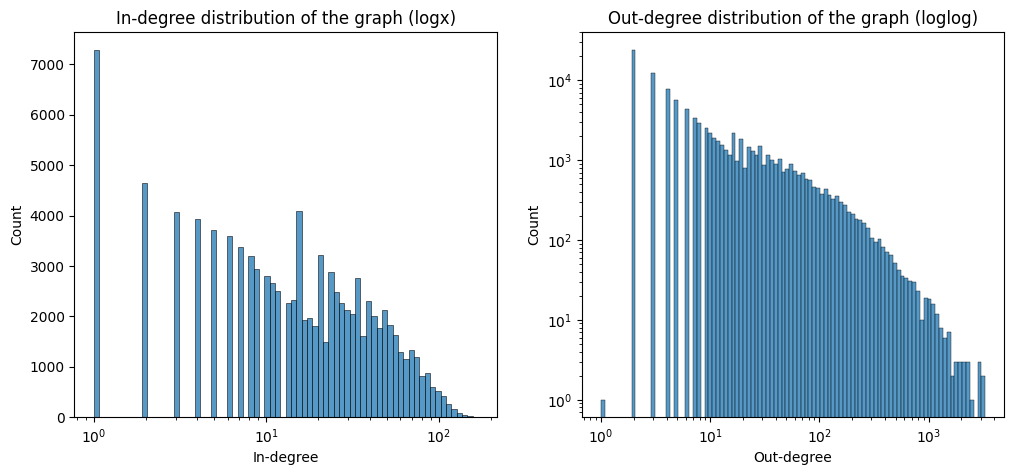

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(in_degrees, ax=ax[0], log_scale=[True, False])
sns.histplot(out_degrees, bins=100, ax=ax[1], log_scale=[True, True])
ax[0].set_xlabel("In-degree")
ax[1].set_xlabel("Out-degree")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
ax[0].set_title("In-degree distribution of the graph (logx)")
ax[1].set_title("Out-degree distribution of the graph (loglog)")
plt.show()

We observe that the in-degree distribution decreases with a trend close to exponential, while the out-degree distribution approximately follows a power law. This follows a similar pattern to what we normally find in social media, considering that we are dealing with a retweet graph and not with a follow graph: in-degree represents the number of retweets by an user, while out-degree represents the number of times a user has been retweeted. Therefore, it is reasonable that the latter has a much heavier tail, since there are celebrities that are retweeted by a very large number of users. On the other side, the number of retweets done by an user only grows to a certain extent, and has a smaller variance.

Interestingly, we also observe that the number of retweets per user has spikes corresponding to multiples of 10. This is a suspicious behavior, and we will investigate it further in the following.

We can consider the graph as undirected and check its degree distribution, combining both in and out degrees.

In [16]:
G_undirected = G.to_undirected()
degrees = [G_undirected.degree(n) for n in G_undirected.nodes()]

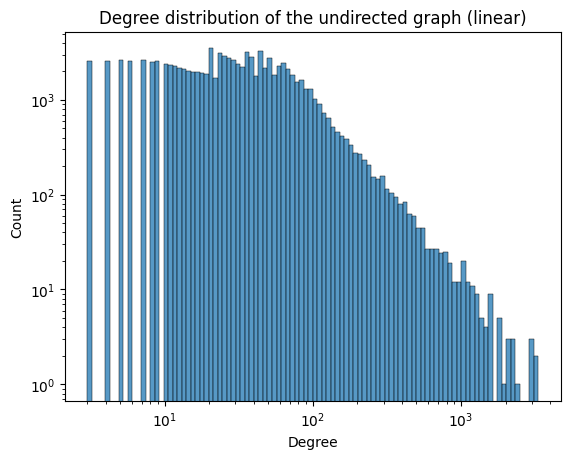

In [17]:
sns.histplot(degrees, bins=100, log_scale=[True, True])
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree distribution of the undirected graph (linear)")
plt.show()

### 1.2 Connectivity

Considering the graph as undirected also allows us to check the connected components

In [18]:
# connected components
cc = list(nx.connected_components(G_undirected))
cc = sorted(cc, key=len, reverse=True)
print(f"The graph has {len(cc)} connected components.")

The graph has 1 connected components.


### 1.3 Feature distribution

In [19]:
features_analyzed = [
    "hate",
    "statuses_count",
    "followers_count",
    "followees_count",
    "favorites_count",
    "listed_count",
    "sentiment",
    "subjectivity",
    "tweet number",
    "retweet number",
    "quote number",
    "status length",
    "baddies",
    "mentions",
]

In [20]:
df[features_analyzed].describe()

,statuses_count,followers_count,followees_count,favorites_count,listed_count,sentiment,subjectivity,tweet number,retweet number,quote number,status length,baddies,mentions
count,1.003860e+05,1.003860e+05,1.003860e+05,1.003860e+05,100386.000000,100009.000000,100009.000000,100009.000000,100009.00000,100009.000000,100009.000000,100009.000000,100009.000000
mean,2.788436e+04,1.131832e+05,2.891717e+03,1.279354e+04,534.857789,0.133680,0.502814,122.751612,72.11093,16.060975,108.729326,21.629353,150.361048
std,6.325047e+04,1.300094e+06,2.097654e+04,3.255763e+04,3742.277767,0.086279,0.066993,52.832745,51.51704,18.919533,30.925540,18.214057,182.703546
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.000000,0.000000,0.000000,0.00000,0.000000,3.000000,0.000000,0.000000
25%,2.436000e+03,7.820000e+02,3.000000e+02,5.660000e+02,10.000000,0.073995,0.466946,84.000000,29.00000,2.000000,85.120000,10.000000,65.000000
50%,9.102000e+03,2.947000e+03,7.070000e+02,2.736500e+03,56.000000,0.121134,0.507132,130.000000,65.00000,10.000000,111.320000,17.000000,125.000000
75%,2.885200e+04,1.437475e+04,1.581000e+03,1.087200e+04,245.000000,0.183746,0.543520,167.000000,109.00000,23.000000,130.705000,28.000000,199.000000
max,7.756870e+06,1.055672e+08,3.078587e+06,1.030071e+06,615331.000000,1.000000,1.000000,200.000000,200.00000,199.000000,912.330000,568.000000,11657.000000


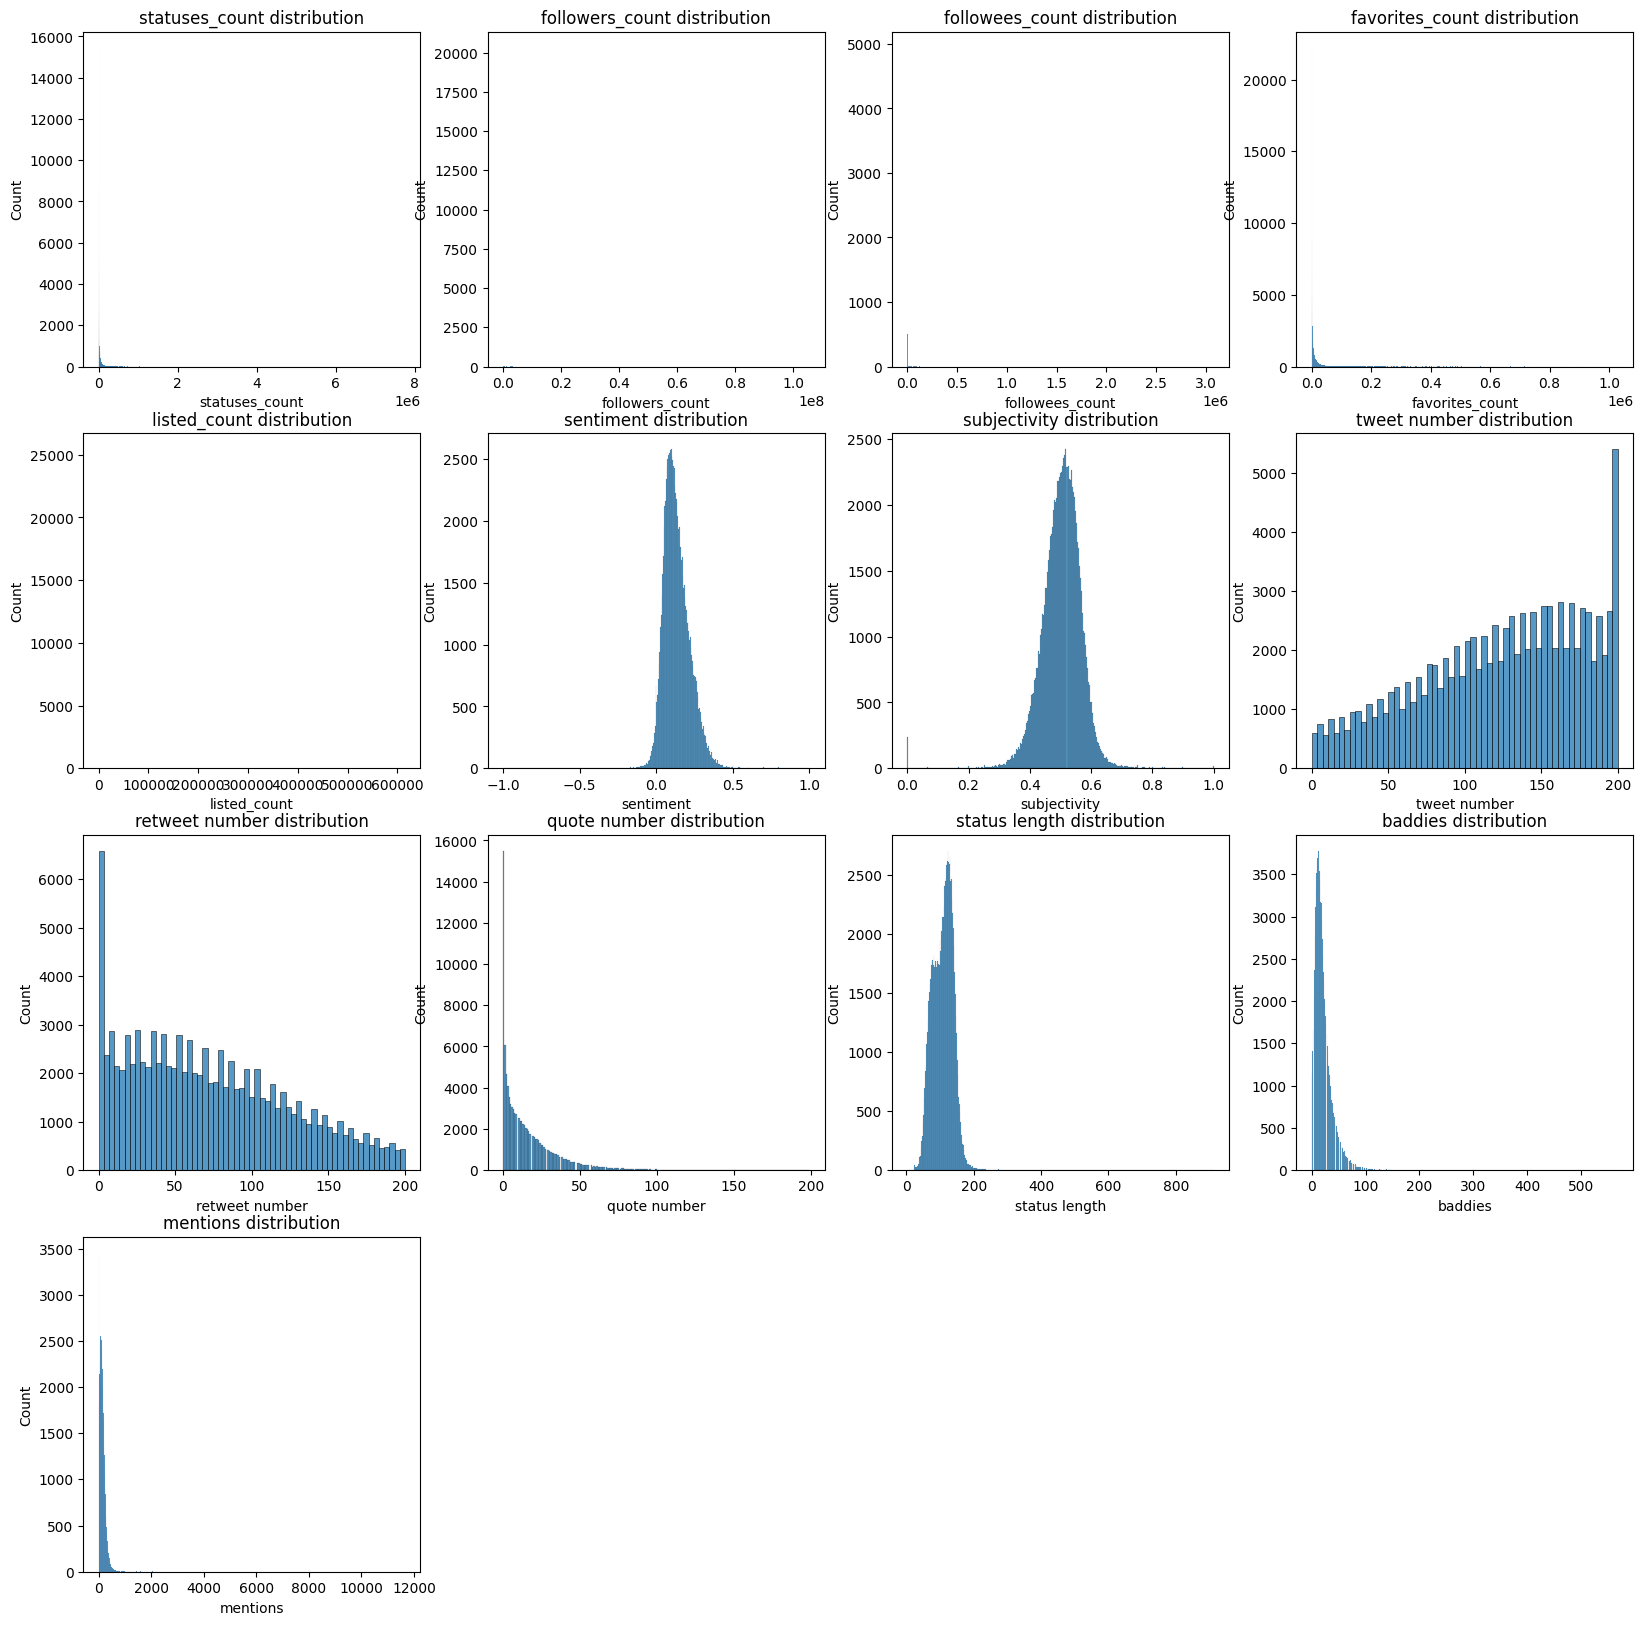

In [21]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i, feature in enumerate(features_analyzed[1:]):
    sns.histplot(df[feature], ax=ax[i // 4, i % 4])
    ax[i // 4, i % 4].set_xlabel(feature)
    ax[i // 4, i % 4].set_ylabel("Count")
    ax[i // 4, i % 4].set_title(f"{feature} distribution")
for i in range(1, 4):
    ax[3, i].set_axis_off()

plt.show()

We repeat the same plots with appropriate logscales, where needed.

In [22]:
logscale = [
    [True, True],
    [True, True],
    [True, True],
    [True, True],
    [True, True],
    [False, False],
    [False, False],
    [False, False],
    [False, False],
    [False, False],
    [False, False],
    [False, True],
    [True, True],
]

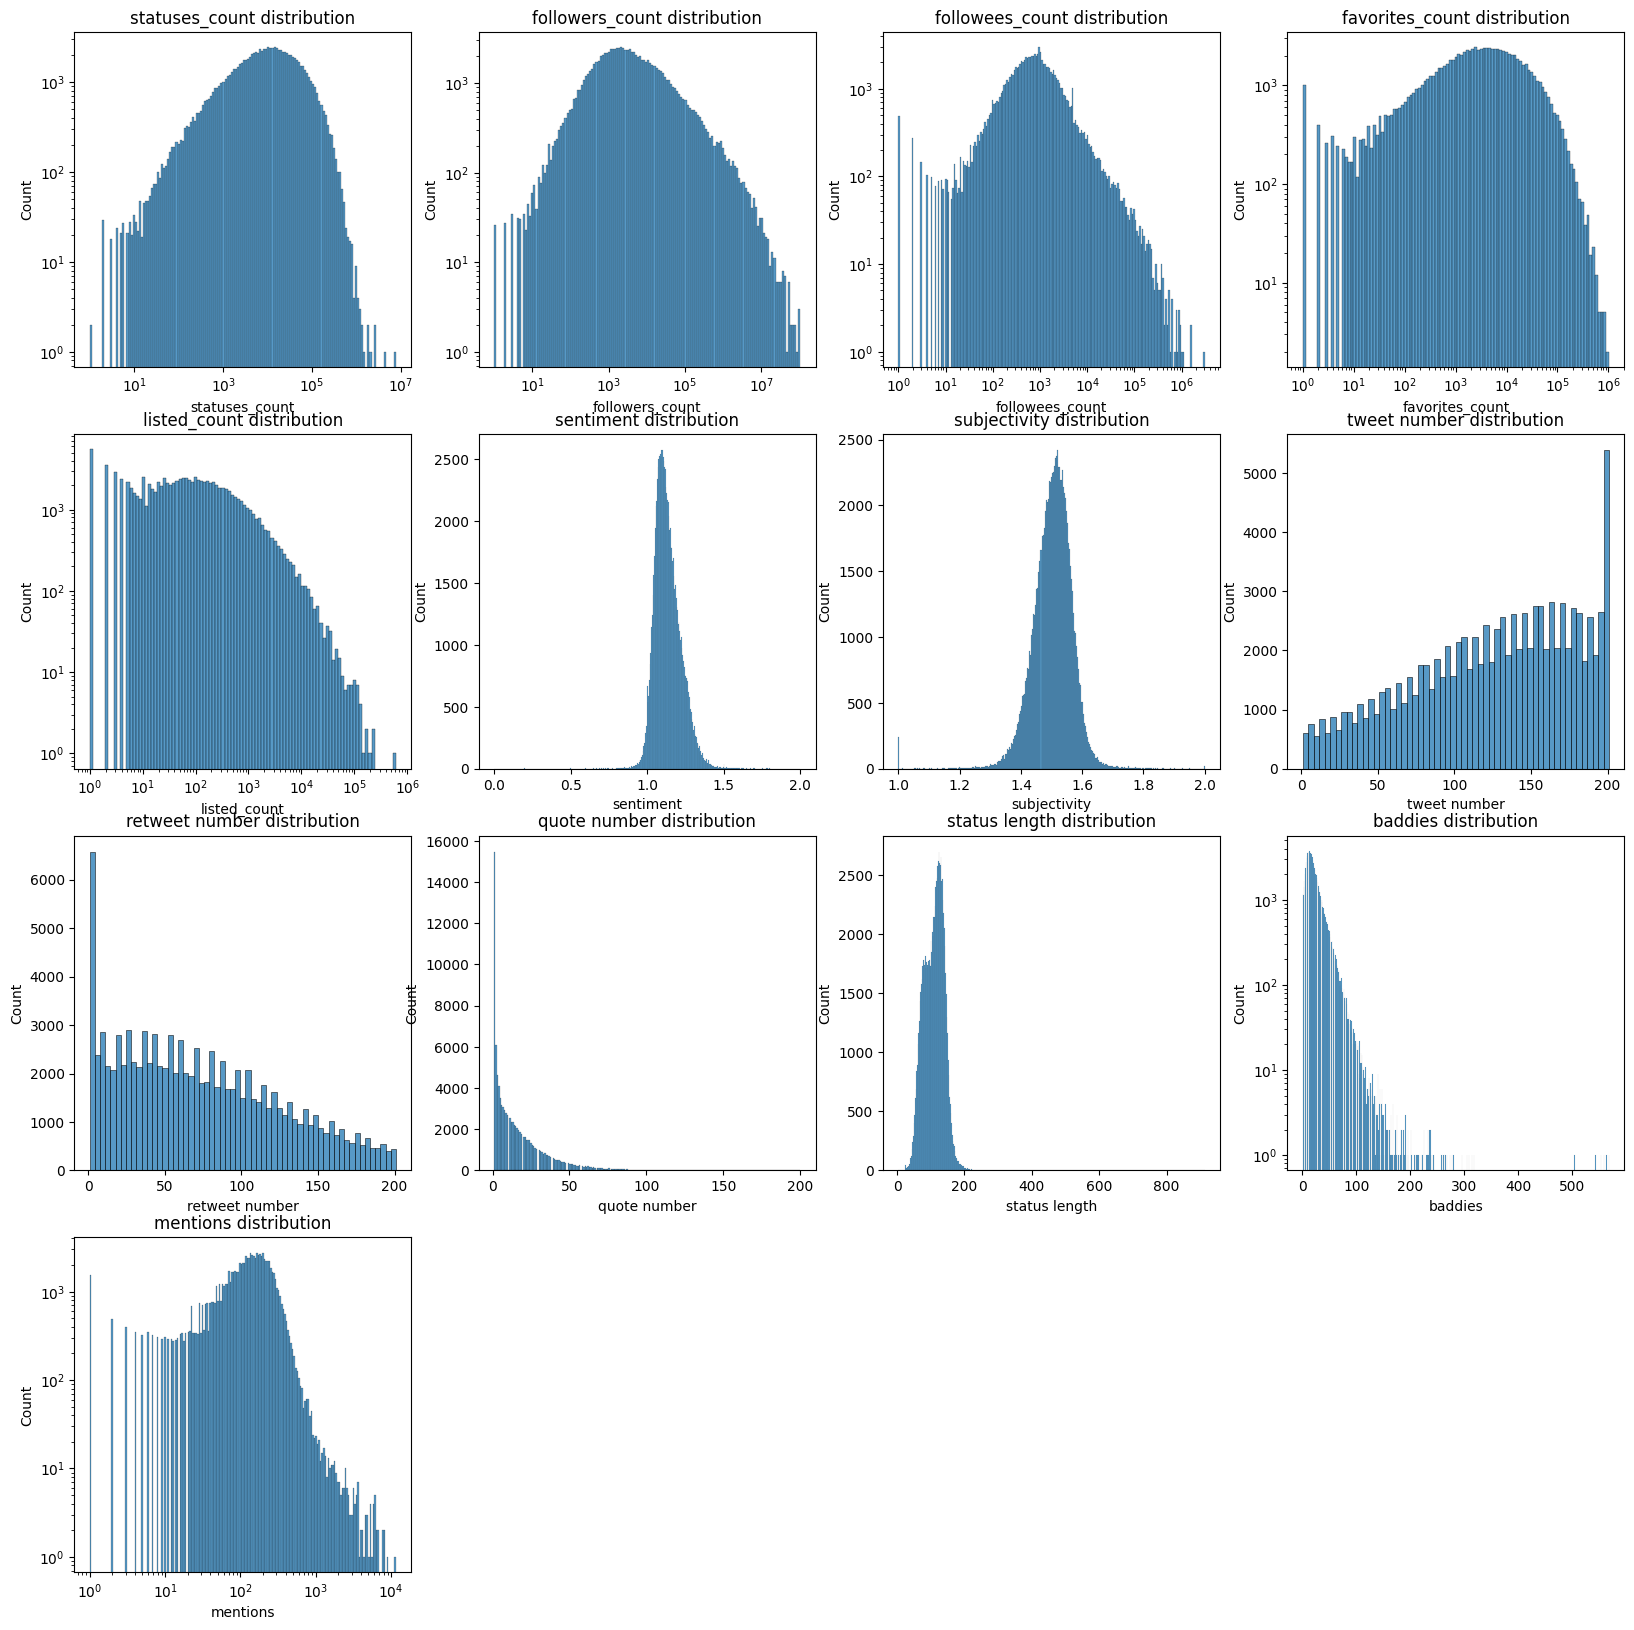

In [23]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i, feature in enumerate(features_analyzed[1:]):
    sns.histplot(df[feature] + 1, ax=ax[i // 4, i % 4], log_scale=logscale[i])
    ax[i // 4, i % 4].set_xlabel(feature)
    ax[i // 4, i % 4].set_ylabel("Count")
    ax[i // 4, i % 4].set_title(f"{feature} distribution")
for i in range(1, 4):
    ax[3, i].set_axis_off()

plt.show()

From a first look at the features, we can see that the dataset includes accounts with a limited number of followers, so that don't belong to celebrities or influencers. 

Let's have a look at the label distribution

In [24]:
counts = df["hate"].value_counts()
print(counts)

other      95415
normal      4427
hateful      544
Name: hate, dtype: int64


The number of hateful users is very limited as compared to the number of non-hateful users. This is a typical case of imbalanced dataset. We will have to take this into account when training our models.

In [25]:
print(
    "Hateful users are {}% of the total, normal users are {}% and unknown users are {}%.".format(
        round(counts["hateful"] / df.shape[0] * 100, 2),
        round(counts["normal"] / df.shape[0] * 100, 2),
        round(counts["other"] / df.shape[0] * 100, 2),
    )
)

Hateful users are 0.54% of the total, normal users are 4.41% and unknown users are 95.05%.


### 1.4. Features by label

TODO: repeat plots with hue=hate, and study pairwise correlations with the label

### 1.5. Subset

Since the retweet graph is very large, we will focus on a subset of it for our analyses. In order to make sure that the chosen sample is representative of the whole graph, we repeat the analyses conducted previously on it and compare the results.

In [31]:
subset_random = df.sample(5000, random_state=42).user_id.astype(str).values
subset_labeled = df[df.hate.isin(["normal", "hateful"])].user_id.astype(str).values

G_random = G.subgraph(subset_random)
G_labeled = G.subgraph(subset_labeled)

In [32]:
print(
    f"The random subset contains {G_random.number_of_nodes()} nodes and {G_random.number_of_edges()} edges."
)
print(
    f"The labeled subset contains {G_labeled.number_of_nodes()} nodes and {G_labeled.number_of_edges()} edges."
)

The random subset contains 5000 nodes and 10437 edges.
The labeled subset contains 4971 nodes and 15141 edges.


In [33]:
in_degrees_random = [G_random.in_degree(n) for n in G_random.nodes()]
out_degrees_random = [G_random.out_degree(n) for n in G_random.nodes()]

in_degrees_labeled = [G_labeled.in_degree(n) for n in G_labeled.nodes()]
out_degrees_labeled = [G_labeled.out_degree(n) for n in G_labeled.nodes()]

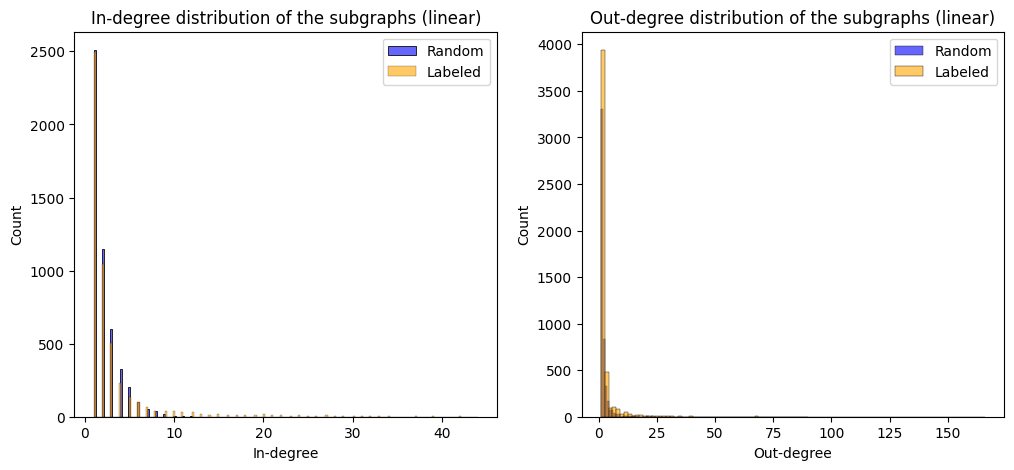

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(in_degrees_random, ax=ax[0], alpha=0.6, color="blue", label="Random")
sns.histplot(in_degrees_labeled, ax=ax[0], alpha=0.6, color="orange", label="Labeled")
sns.histplot(
    out_degrees_random, bins=100, ax=ax[1], alpha=0.6, color="blue", label="Random"
)
sns.histplot(
    out_degrees_labeled, bins=100, ax=ax[1], alpha=0.6, color="orange", label="Labeled"
)
ax[0].set_xlabel("In-degree")
ax[1].set_xlabel("Out-degree")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
ax[0].legend()
ax[1].legend(["Random", "Labeled"])
ax[0].set_title("In-degree distribution of the subgraphs (linear)")
ax[1].set_title("Out-degree distribution of the subgraphs (linear)")
plt.show()

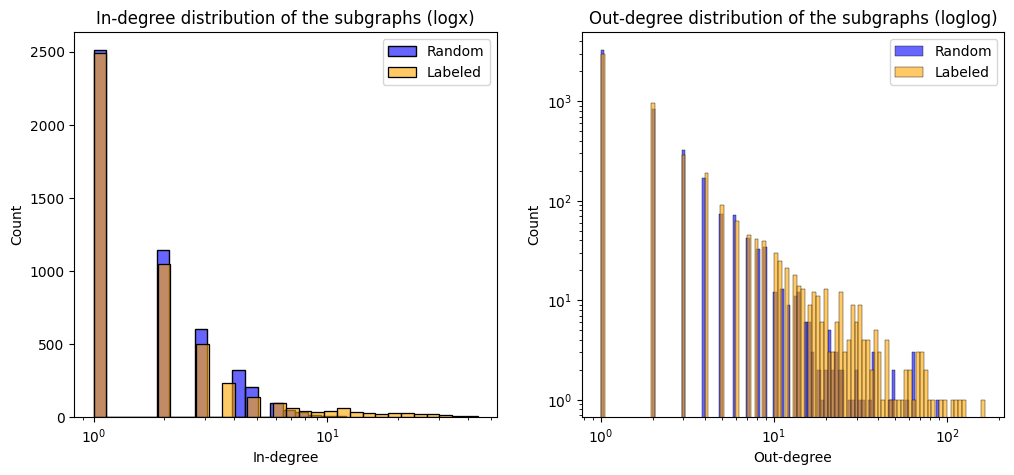

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    in_degrees_random,
    ax=ax[0],
    alpha=0.6,
    color="blue",
    label="Random",
    log_scale=[True, False],
)
sns.histplot(
    in_degrees_labeled,
    ax=ax[0],
    alpha=0.6,
    color="orange",
    label="Labeled",
    log_scale=[True, False],
)
sns.histplot(
    out_degrees_random,
    bins=100,
    ax=ax[1],
    alpha=0.6,
    color="blue",
    label="Random",
    log_scale=[True, True],
)
sns.histplot(
    out_degrees_labeled,
    bins=100,
    ax=ax[1],
    alpha=0.6,
    color="orange",
    label="Labeled",
    log_scale=[True, True],
)
ax[0].set_xlabel("In-degree")
ax[1].set_xlabel("Out-degree")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
ax[0].legend()
ax[1].legend(["Random", "Labeled"])
ax[0].set_title("In-degree distribution of the subgraphs (logx)")
ax[1].set_title("Out-degree distribution of the subgraphs (loglog)")
plt.show()

# 2. Network models
We simulate the network using different network models and compare the results with the real network. We use the following network models:
1. Erdos-Renyi
2. Watts-Strogatz
3. Barabasi-Albert


Let's simulate a network using different models to see which one approximates better the real network

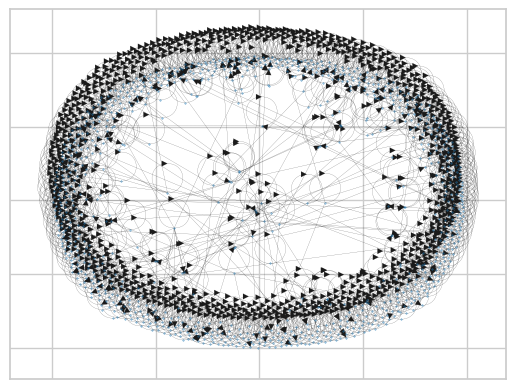

In [ ]:
# take a sample of the graph
nodes_sample = np.random.choice(G.nodes(), 1000, replace=False)
G_sample = G.subgraph(nodes_sample)
nx.draw_networkx(G_sample, with_labels=False, node_size=0.1, width=0.1)

In [ ]:
average_clustering_coeffient = nx.average_clustering(G)
print(average_clustering_coeffient)

0.05665756186782143


The average clustering coefficient is 0.056, which is a pretty low value. 

##### a. Configuration model

We fit a configuration model based on the degree distribution of the real network

In [ ]:
degrees = [G.degree(n) for n in G.nodes()]

G_config = nx.configuration_model(degrees)

print(
    "Configuration model has {} nodes and {} edges.".format(
        G_config.number_of_nodes(), G_config.size()
    )
)
print("Original graph has {} nodes and {} edges.".format(G.number_of_nodes(), G.size()))

Configuration model has 100386 nodes and 2286592 edges.
Original graph has 100386 nodes and 2286592 edges.


In [ ]:
print("Number of self-loops in original graph: {}".format(nx.number_of_selfloops(G)))

Number of self-loops in original graph: 100386


#### CHECK: why does each node has a self-loop??

In [ ]:
print(
    "Number of self-loops in configuration model: {}, Number of connected components in configuration model: {}".format(
        nx.number_of_selfloops(G_config), nx.number_connected_components(G_config)
    )
)

Number of self-loops in configuration model: 88, Number of connected components in configuration model: 1


##### b. Watts-Strogatz model

We simulate a Watts-Strogatz model with the same number of nodes and average degree as the real network. 
The parameter $k$ is the average degree of the network, and we fit it to the average degree of the real network. As seen in the course, we fit the parameter $p$ to make this model have the same average clustering coefficient as the real network.

In [ ]:
# TODO: for following tasks decide whether to use original graph or take a sample
# computations on the size of the original graph are very very expensive
# so we should choose a reasonable subgraph

# FIXME:
# Problem: if we sample a small subgraph, it is unlikely to be connected
# This means that it will actually not reproduce correctly the original graph

G_undirected = G_sample.to_undirected()

In [ ]:
# Here we compute some statistics on the graph that we will need to fit Watts-Strogatz models.

cc = nx.average_clustering(G_undirected)

# avg_shortest_path = nx.average_shortest_path_length(G_undirected)
# since it is not connected, we compute the average shortest path for each connected component and then average them
avg_shortest_path = 0
for component in nx.connected_components(G_undirected):
    avg_shortest_path += nx.average_shortest_path_length(
        G_undirected.subgraph(component)
    ) * len(component)

avg_shortest_path /= G_undirected.number_of_nodes()

k = int(np.round(np.mean(degrees)))
n = len(G_undirected.nodes())

100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


Scaled clustering coefficient of citation graph: 0.005507575757575699
Scaled average shortest path length of citation graph: 0.10711245496233214


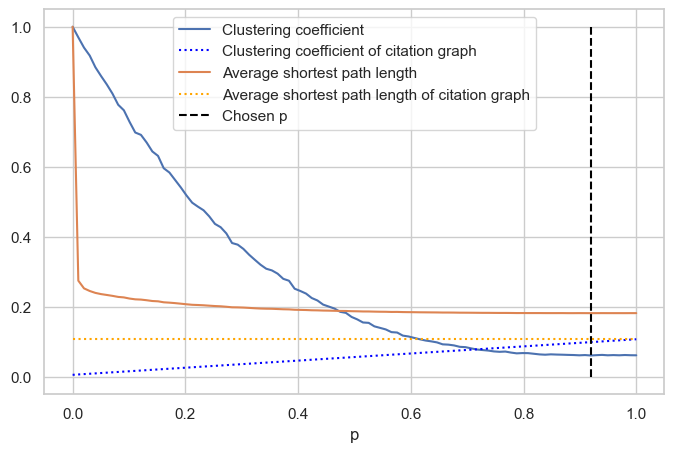

Optimal value of p: 0.9191919191919192
Scaled clustering coefficient difference at p_opt: 0.055220506473054175
Scaled average shortest path length difference at p_opt: 0.07457535335338315


In [ ]:
probs = np.linspace(0, 1, 100)
ccs = []
ds = []
for p in tqdm(probs):
    G = nx.watts_strogatz_graph(n, k, p)
    ccs.append(nx.average_clustering(G))
    ds.append(nx.average_shortest_path_length(G))

G_p0 = nx.watts_strogatz_graph(n, k, 0)
cc_0 = nx.average_clustering(G_p0)
d_0 = nx.average_shortest_path_length(G_p0)

ccs = [x / cc_0 for x in ccs]
ds = [x / d_0 for x in ds]


cc_scaled = cc / cc_0
d_scaled = avg_shortest_path / d_0

print("Scaled clustering coefficient of retweet graph:", cc_scaled)
print("Scaled average shortest path length of retweet graph:", d_scaled)

# we plot the two values on the same plot
plt.figure(figsize=(8, 5))
plt.plot(probs, ccs, label="Clustering coefficient")
plt.plot(
    [0, 1],
    [cc_scaled, cc_scaled],
    label="Clustering coefficient of retweet graph",
    linestyle="dotted",
    color="blue",
)
plt.plot(probs, ds, label="Average shortest path length")
plt.plot(
    [0, 1],
    [d_scaled, d_scaled],
    label="Average shortest path length of retweet graph",
    linestyle="dotted",
    color="orange",
)
plt.xlabel("p")

# we choose the value of p that minimizes the difference between the scaled CC for the retweet graph with the
# scaled CC for the WS graph at p and the scaled average shortest path length for the citation graph with the
# scaled average shortest path length for the WS graph at p

differences = []
for i in range(len(probs)):
    differences.append(abs(cc_scaled - ccs[i]) + abs(d_scaled - ds[i]))

p_opt = probs[np.argmin(differences)]

# add a vertical line to the plot to show the optimal value of p
plt.plot([p_opt, p_opt], [0, 1], linestyle="dashed", label="Chosen p", color="black")
plt.legend()
plt.show()

print("Optimal value of p:", p_opt)
print(
    "Scaled clustering coefficient difference at p_opt:",
    abs(cc_scaled - ccs[np.argmin(differences)]),
)
print(
    "Scaled average shortest path length difference at p_opt:",
    abs(d_scaled - ds[np.argmin(differences)]),
)

G_ws = nx.watts_strogatz_graph(n, k, p_opt, seed=42)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# 3. Graphlets

In [55]:
# TODO: Change this with the chosen subset (random, labeled, or the whole graph)
G_graphlets = G_random

In [56]:
triadic_census = nx.triadic_census(G_graphlets)

In [67]:
df_G = pd.DataFrame.from_dict({k: [v] for k, v in triadic_census.items()})
df_G

,003,012,102,021D,021U,021C,111D,111U,030T,030C,201,120D,120U,120C,210,300
0,20794823508,24851593,1117376,30473,5066,4567,454,1357,348,9,47,63,54,28,45,12


In [58]:
triadic_types = {key: nx.DiGraph() for key in triadic_census.keys()}

triadic_types["003"].add_nodes_from([1, 2, 3])
triadic_types["012"].add_nodes_from([1, 2, 3])
triadic_types["012"].add_edges_from([(1, 2)])
triadic_types["021C"].add_edges_from([(1, 2), (2, 3)])
triadic_types["021D"].add_edges_from([(2, 1), (2, 3)])
triadic_types["021U"].add_edges_from([(1, 2), (3, 2)])
triadic_types["030C"].add_edges_from([(1, 3), (3, 2), (2, 1)])
triadic_types["030T"].add_edges_from([(1, 3), (3, 2), (1, 2)])
triadic_types["102"].add_nodes_from([1, 2, 3])
triadic_types["102"].add_edges_from([(1, 2), (2, 1)])
triadic_types["111D"].add_edges_from([(1, 3), (3, 1), (2, 3)])
triadic_types["111U"].add_edges_from([(1, 3), (3, 1), (3, 2)])
triadic_types["120C"].add_edges_from([(1, 3), (3, 1), (1, 2), (2, 3)])
triadic_types["120D"].add_edges_from([(1, 3), (3, 1), (2, 1), (2, 3)])
triadic_types["120U"].add_edges_from([(1, 3), (3, 1), (1, 2), (3, 2)])
triadic_types["201"].add_edges_from([(1, 2), (2, 1), (1, 3), (3, 1)])
triadic_types["210"].add_edges_from([(1, 2), (1, 3), (3, 1), (2, 3), (3, 2)])
triadic_types["300"].add_edges_from([(1, 2), (1, 3), (3, 1), (2, 3), (3, 2), (2, 1)])

In [59]:
layout = {1: np.array([-1, -1 / 3]), 3: np.array([1, -1 / 3]), 2: np.array([0, 2 / 3])}

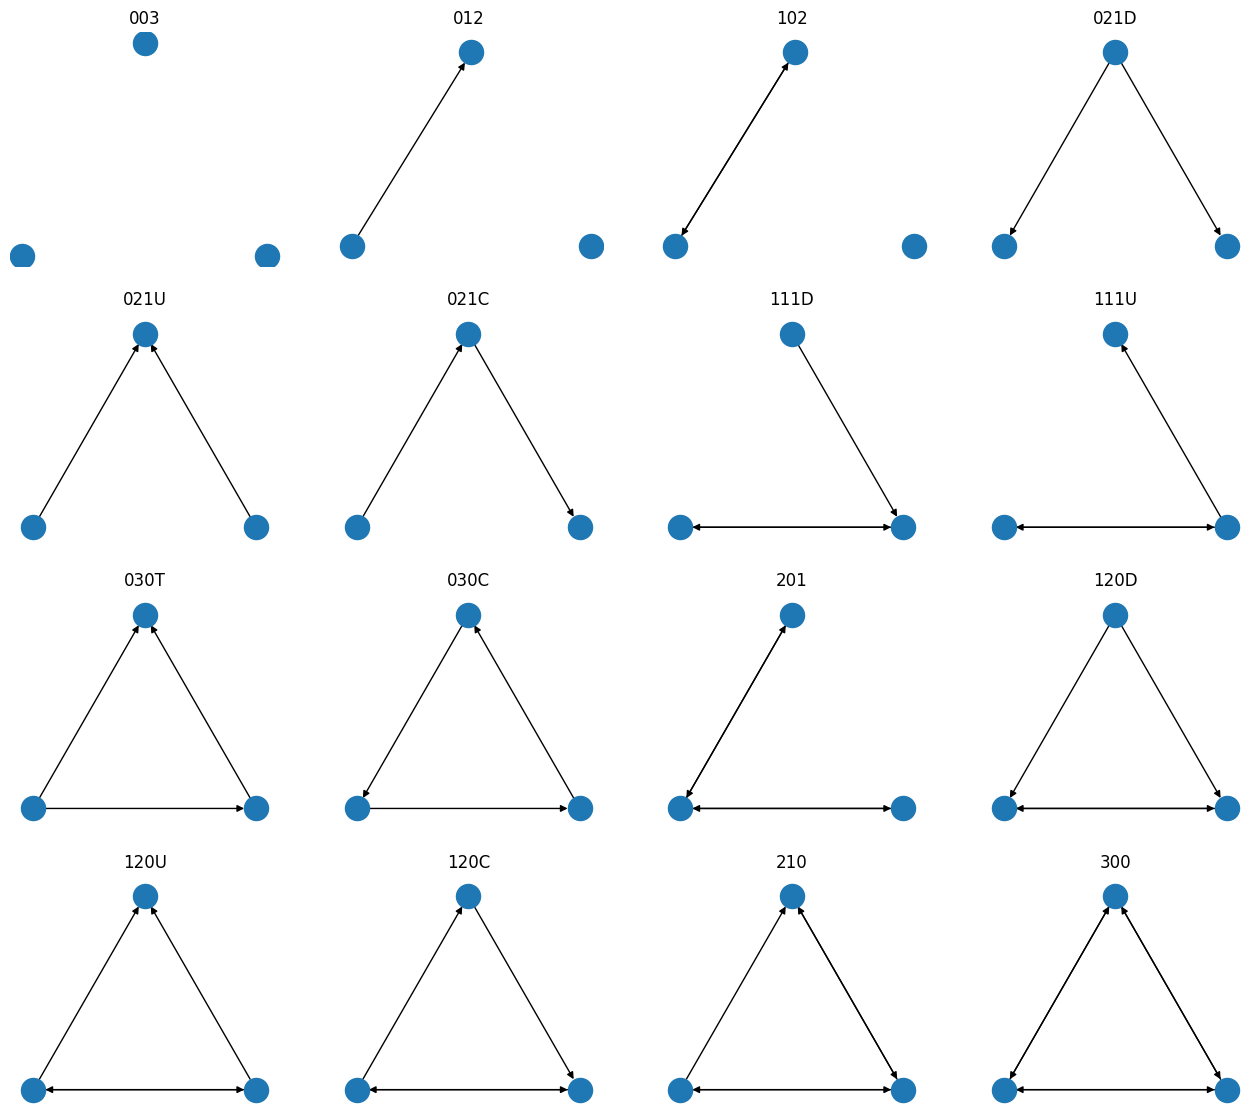

In [60]:
fig, ax = plt.subplots(4, 4, figsize=(16, 14))
plt.rcParams["figure.facecolor"] = "white"
for i, axs in enumerate(ax.flatten()):
    nx.draw_networkx(
        list(triadic_types.values())[i], pos=layout, ax=axs, with_labels=False
    )
    axs.axis("off")
    axs.set_title(list(triadic_types.keys())[i])
plt.savefig("triads.pdf")
plt.show()

In [62]:
din = [d for n, d in G_graphlets.in_degree()]
dout = [d for n, d in G_graphlets.out_degree()]

ntimes = 8

null_census = []
for _ in range(ntimes):
    # TODO: Change Network model with the best one, found in the previous section
    G_null = nx.directed_configuration_model(din, dout, create_using=nx.DiGraph)
    res = nx.triadic_census(G_null)
    null_census.append(pd.DataFrame.from_dict({k: [v] for k, v in res.items()}))
df_null = pd.concat(null_census)

In [69]:
# Compute Z-values
Z = (df_G.loc[0] - df.mean(axis=0)) / df.std(axis=0)

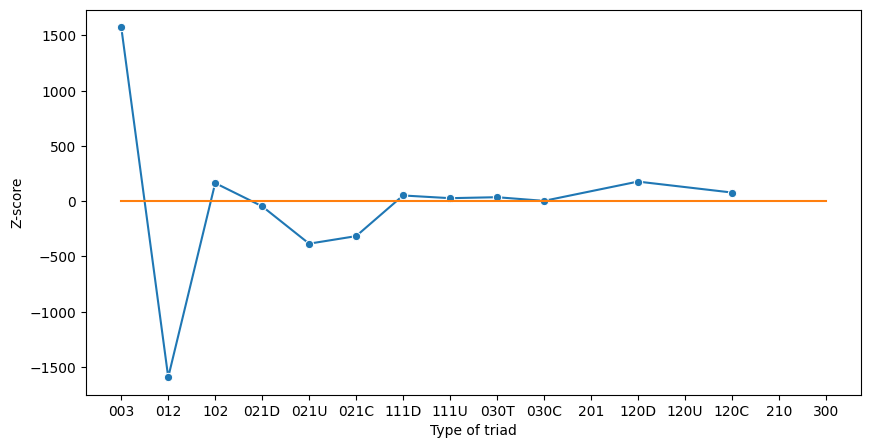

In [70]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=Z.index, y=Z.values, marker="o")
sns.lineplot(x=Z.index, y=[0] * len(Z.index))
plt.xlabel("Type of triad")
plt.ylabel("Z-score")
plt.savefig("z-scores.pdf")
plt.show()